[*********************100%***********************]  1 of 1 completed


y_train min: 0.0, max: 1.0
y_test min: 0.33085575699806213, max: 1.1745538711547852
Epoch 10/200, Loss: 0.000807
Epoch 20/200, Loss: 0.000642
Epoch 30/200, Loss: 0.000525
Epoch 40/200, Loss: 0.000421
Epoch 50/200, Loss: 0.000471
Epoch 60/200, Loss: 0.000342
Epoch 70/200, Loss: 0.000348
Epoch 80/200, Loss: 0.000311
Epoch 90/200, Loss: 0.000323
Epoch 100/200, Loss: 0.000309
Epoch 110/200, Loss: 0.000292
Epoch 120/200, Loss: 0.000305
Epoch 130/200, Loss: 0.000304
Epoch 140/200, Loss: 0.000295
Epoch 150/200, Loss: 0.000310
Epoch 160/200, Loss: 0.000310
Epoch 170/200, Loss: 0.000290
Epoch 180/200, Loss: 0.000280
Epoch 190/200, Loss: 0.000292
Epoch 200/200, Loss: 0.000293
Predictions before inverse transform: [[0.40911722]
 [0.42153814]
 [0.42755365]
 [0.43337563]
 [0.43430886]
 [0.43330085]
 [0.45276442]
 [0.46543482]
 [0.46671727]
 [0.46007687]]
Predictions range after inverse transform: 144.0032501220703 to 462.3989562988281
Actuals range after inverse transform: 142.0500030517578 to 479.

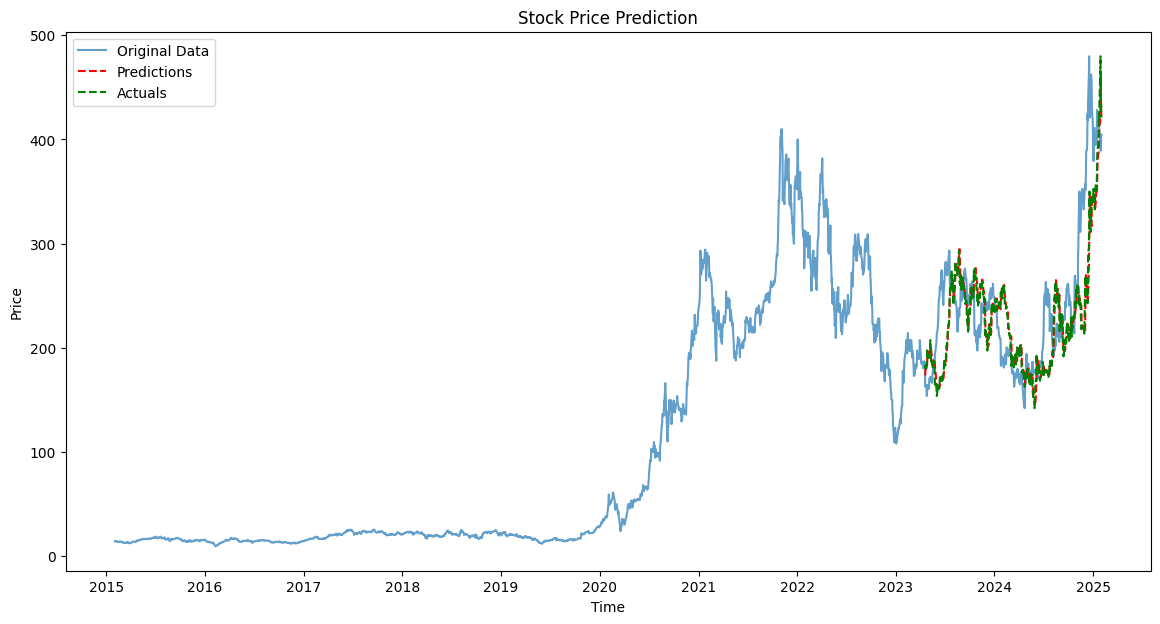

In [2]:
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dataset():
    # TSLA 주가 데이터 다운로드 (예: 최근 10년간의 일일 주가)
    ticker = "TSLA"
    data = yf.download(ticker, period="10y", interval="1d")
    data = data[['Close', 'Volume', 'Open', 'High', 'Low']]

    # Train-test split
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size].copy()
    test_data = data[train_size:].copy()

    # 학습 데이터에 대해 스케일링
    close_scaler = MinMaxScaler(feature_range=(0, 1))
    volume_scaler = MinMaxScaler(feature_range=(0, 1))
    open_scaler = MinMaxScaler(feature_range=(0, 1))
    high_scaler = MinMaxScaler(feature_range=(0, 1))
    low_scaler = MinMaxScaler(feature_range=(0, 1))

    train_data["Close_scaled"] = close_scaler.fit_transform(train_data["Close"].values.reshape(-1, 1))
    train_data["Volume_scaled"] = volume_scaler.fit_transform(train_data["Volume"].values.reshape(-1, 1))
    train_data["Open_scaled"] = open_scaler.fit_transform(train_data["Open"].values.reshape(-1, 1))
    train_data["High_scaled"] = high_scaler.fit_transform(train_data["High"].values.reshape(-1, 1))
    train_data["Low_scaled"] = low_scaler.fit_transform(train_data["Low"].values.reshape(-1, 1))

    # 테스트 데이터는 학습 데이터의 스케일러를 사용하여 변환
    test_data["Close_scaled"] = close_scaler.transform(test_data["Close"].values.reshape(-1, 1))
    test_data["Volume_scaled"] = volume_scaler.transform(test_data["Volume"].values.reshape(-1, 1))
    test_data["Open_scaled"] = open_scaler.transform(test_data["Open"].values.reshape(-1, 1))
    test_data["High_scaled"] = high_scaler.transform(test_data["High"].values.reshape(-1, 1))
    test_data["Low_scaled"] = low_scaler.transform(test_data["Low"].values.reshape(-1, 1))

    # 시퀀스 데이터 준비 함수
    def create_sequences(dataset, time_step=30):
        X, y = [], []
        for i in range(len(dataset) - time_step - 1):
            X.append(dataset[["Close_scaled", "Volume_scaled", "Open_scaled", "High_scaled", "Low_scaled"]].iloc[i:i+time_step].values)
            y.append(dataset["Close_scaled"].iloc[i+time_step])
        return np.array(X), np.array(y)

    time_step = 30
    X_train, y_train = create_sequences(train_data, time_step)
    X_test, y_test = create_sequences(test_data, time_step)

    # Tensor 변환 및 차원 추가
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

    print(f"y_train min: {y_train.min()}, max: {y_train.max()}")
    print(f"y_test min: {y_test.min()}, max: {y_test.max()}")

    # TensorDataset 및 DataLoader 생성
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader, close_scaler, data

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # 마지막 타임스텝의 출력만 사용
        out = self.fc(out)  # 출력층에 활성화 함수 없음
        return out

def train_lstm_model(model, train_loader, config):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    num_epochs = config["train"]["num_epochs"]
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        scheduler.step()
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

def evaluate(model, test_loader, close_scaler):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # 역변환
    predictions_inversed = close_scaler.inverse_transform(predictions)
    actuals_inversed = close_scaler.inverse_transform(actuals)

    print(f"Predictions before inverse transform: {predictions[:10]}")
    print(f"Predictions range after inverse transform: {predictions_inversed.min()} to {predictions_inversed.max()}")
    print(f"Actuals range after inverse transform: {actuals_inversed.min()} to {actuals_inversed.max()}")

    return predictions_inversed, actuals_inversed

def plot_predictions(predictions, actuals, data):
    print(f"Predictions before inverse transform: {predictions[:10]}")


    # 테스트 데이터가 시작하는 인덱스
    test_start_idx = len(data) - len(predictions)

    print(f"Original data range: {data['Close'].min()} to {data['Close'].max()}")
    print(f"Predictions range after inverse transform: {predictions.min()} to {predictions.max()}")
    print(f"Actuals range after inverse transform: {actuals.min()} to {actuals.max()}")

    # 시각화
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data["Close"], label="Original Data", alpha=0.7)
    plt.plot(data.index[test_start_idx:], predictions, label="Predictions", color="red", linestyle="--")
    plt.plot(data.index[test_start_idx:], actuals, label="Actuals", color="green", linestyle="--")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

def main():
    # 데이터 준비
    train_loader, test_loader, close_scaler, data = dataset()

    # 모델 초기화
    model = LSTMModel(
        input_size=5, 
        hidden_size=64, 
        num_layers=2, 
        output_size=1, 
        dropout=0.2).to(device)

    # 모델 학습
    config = {
        "train": {
            "num_epochs": 200,
            "learning_rate": 0.001,
            "input_size": 5,
            "hidden_size": 64,
            "num_layers": 2,
            "output_size": 1
        }
    }
    train_lstm_model(model, train_loader, config)

    # 모델 평가
    predictions, actuals = evaluate(model, test_loader, close_scaler)

    # 예측 값 시각화
    plot_predictions(predictions, actuals, data)

if __name__ == "__main__":
    main()
